## Cobb County Right Angle Crash Prediction - XGBOOST, ESRI RandomFS, ConvLSTM
### Import the modules and libraries.
Traffic accedidents have been one of the most challenge public saftey issues. Accident prediction is important for optimizing public transportation, enabling safer driving and improving the transportation infrastructure. Right Angle crashes is one of the severe accidents in Cobb County. Finding the factors which contribute the right angle crashes is a uique changllenge as the causes of the accidents are complex. Here I use XGBoost gradient tree and Randome Forest Classifier to search for the major factors and compare both algorithems for the optimum results. DATA as indicated by previous feature engineering notebook is from 2018-2020 of 3 year Cobb county crash database. Both algorithems agree on top of 8 variables that contribute the accidents----proximity_nearest_intersection, average slope, popuation density,solar azimuth,solar elevation,segment curvature,segmentlength, speed limit. The F1 scores and precision and recalls outputs show that ESRI Random Forest classifier outperforms XGBoost in many aspects. Emprical evaluation of ConvLSTM to predict right angle crash by time series will be implemented in the following month or so(not done yet).

In [1]:
import os
import arcpy
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import plot_tree
from sklearn.model_selection import train_test_split,GridSearchCV, StratifiedKFold, KFold,StratifiedShuffleSplit
from sklearn.metrics import accuracy_score,precision_score, recall_score,roc_auc_score, roc_curve, average_precision_score,precision_recall_curve,f1_score,classification_report,confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import shap
import datetime
%matplotlib inline

In [2]:
 df = pd.read_csv('trainingData/rightAnglecrash.csv')

In [3]:
df.head()

,Unnamed: 0,OBJECTID,ACCIDENTDATE,ROADSURFACE,SEVERITY,WEATHER,DESCRIPTION,CONTROLTYPE,LIGHTCONDITIONS,V1_MOVEMENT,...,NUMLANES,SPEED_LIMIT,LANE_TYPE,LENGTH,curv,Avg_Slope,SHAPE,RIGHTANGLE,solar_azimuth,solar_elevation
0,0,1,2018-03-18 23:10:00.000001,2.0,0.0,3.0,4.0,7.0,4.0,6.0,...,4,25.0,1,496.87168,1.010868,9.374528,"{'x': 2200251.299880162, 'y': 1422066.99999782...",0.0,264.483218,7.105017
1,1,2,2018-03-18 22:31:00.000000,1.0,0.0,1.0,6.0,7.0,5.0,5.0,...,2,35.0,1,140.24278,1.001089,7.413122,"{'x': 2173367.799841497, 'y': 1399011.09991548...",0.0,258.818460,15.056053
2,2,3,2018-03-18 21:56:00.000001,1.0,4.0,2.0,5.0,2.0,4.0,3.0,...,2,35.0,1,44.20401,1.000000,31.375962,"{'x': 2166057.800025828, 'y': 1405272.50012232...",0.0,253.354698,22.092605
3,3,4,2018-03-18 17:02:00.000000,1.0,4.0,1.0,3.0,7.0,1.0,5.0,...,6,65.0,2,2688.72923,1.005217,8.160925,"{'x': 2197852.34962558, 'y': 1390927.089508742...",0.0,161.268741,54.001393
4,4,5,2018-03-18 17:27:00.000000,1.0,0.0,1.0,3.0,7.0,1.0,5.0,...,6,65.0,2,2688.72923,1.005217,8.160925,"{'x': 2198188.9316295795, 'y': 1391296.8066170...",0.0,171.863581,55.218132


In [4]:
df.dtypes

Unnamed: 0                          int64
OBJECTID                            int64
ACCIDENTDATE                       object
ROADSURFACE                       float64
SEVERITY                          float64
WEATHER                           float64
DESCRIPTION                       float64
CONTROLTYPE                       float64
LIGHTCONDITIONS                   float64
V1_MOVEMENT                       float64
V1_FACTOR1                        float64
V1_E1                             float64
pop_density                       float64
proximity_nearest_intersection    float64
FUNCTIONALCLASS                    object
NUMLANES                            int64
SPEED_LIMIT                       float64
LANE_TYPE                           int64
LENGTH                            float64
curv                              float64
Avg_Slope                         float64
SHAPE                              object
RIGHTANGLE                        float64
solar_azimuth                     

In [5]:
 df.drop(['Unnamed: 0','OBJECTID','ACCIDENTDATE','DESCRIPTION','SHAPE'], axis=1
, inplace=True)

In [6]:
 df.isnull().any(axis=0)

ROADSURFACE                       False
SEVERITY                          False
WEATHER                           False
CONTROLTYPE                       False
LIGHTCONDITIONS                   False
V1_MOVEMENT                       False
V1_FACTOR1                        False
V1_E1                             False
pop_density                       False
proximity_nearest_intersection    False
FUNCTIONALCLASS                   False
NUMLANES                          False
SPEED_LIMIT                       False
LANE_TYPE                         False
LENGTH                            False
curv                              False
Avg_Slope                         False
RIGHTANGLE                        False
solar_azimuth                     False
solar_elevation                   False
dtype: bool

In [7]:
df.loc[df['NUMLANES']==-999,'NUMLANES']=6 #interstate 

In [8]:
#these fields need to tranform to one hot encoder variables
ohe_fld=['ROADSURFACE','SEVERITY','WEATHER','CONTROLTYPE','LIGHTCONDITIONS','V1_MOVEMENT','V1_FACTOR1','V1_E1','FUNCTIONALCLASS','NUMLANES','LANE_TYPE']
X = pd.get_dummies(df,columns=ohe_fld)

In [9]:
X.head()

,pop_density,proximity_nearest_intersection,SPEED_LIMIT,LENGTH,curv,Avg_Slope,RIGHTANGLE,solar_azimuth,solar_elevation,ROADSURFACE_1.0,...,FUNCTIONALCLASS_RAMP,NUMLANES_1,NUMLANES_2,NUMLANES_3,NUMLANES_4,NUMLANES_5,NUMLANES_6,NUMLANES_7,LANE_TYPE_1,LANE_TYPE_2
0,2136.585366,0.000000,25.0,496.87168,1.010868,9.374528,0.0,264.483218,7.105017,0,...,0,0,0,0,1,0,0,0,1,0
1,2178.181818,0.000000,35.0,140.24278,1.001089,7.413122,0.0,258.818460,15.056053,1,...,0,0,1,0,0,0,0,0,1,0
2,3075.581395,0.000000,35.0,44.20401,1.000000,31.375962,0.0,253.354698,22.092605,1,...,0,0,1,0,0,0,0,0,1,0
3,2075.000000,340.081911,65.0,2688.72923,1.005217,8.160925,0.0,161.268741,54.001393,1,...,0,0,0,0,0,0,1,0,0,1
4,2075.000000,442.469009,65.0,2688.72923,1.005217,8.160925,0.0,171.863581,55.218132,1,...,0,0,0,0,0,0,1,0,0,1


In [10]:
#these fields need to be scaled using scikit-learn's minmaxScaler
scale_fld=['pop_density','proximity_nearest_intersection','SPEED_LIMIT','LENGTH','curv','Avg_Slope','solar_azimuth','solar_elevation']
scaler = MinMaxScaler()
scale_values = X.loc[:,scale_fld]
scale_values = scaler.fit_transform(scale_values)
X.loc[:,scale_fld]=scale_values
Y=X.RIGHTANGLE


In [11]:
X.drop(['RIGHTANGLE'], axis=1, inplace=True)

In [12]:
Y.value_counts()/Y.count()*100 # 77% are negative and 23 % are postive right angle crash for training.

0.0    77.279305
1.0    22.720695
Name: RIGHTANGLE, dtype: float64

In [13]:
X.head()

,pop_density,proximity_nearest_intersection,SPEED_LIMIT,LENGTH,curv,Avg_Slope,solar_azimuth,solar_elevation,ROADSURFACE_1.0,ROADSURFACE_2.0,...,FUNCTIONALCLASS_RAMP,NUMLANES_1,NUMLANES_2,NUMLANES_3,NUMLANES_4,NUMLANES_5,NUMLANES_6,NUMLANES_7,LANE_TYPE_1,LANE_TYPE_2
0,0.112730,0.000000,0.333333,0.042321,0.000494,0.014862,0.734751,0.544450,0,1,...,0,0,0,0,1,0,0,0,1,0
1,0.114996,0.000000,0.500000,0.011835,0.000049,0.011752,0.719013,0.594355,1,0,...,0,0,1,0,0,0,0,0,1,0
2,0.163864,0.000000,0.500000,0.003626,0.000000,0.049741,0.703832,0.638520,1,0,...,0,0,1,0,0,0,0,0,1,0
3,0.109377,0.144325,1.000000,0.229688,0.000237,0.012938,0.447984,0.838796,1,0,...,0,0,0,0,0,0,1,0,0,1
4,0.109377,0.187776,1.000000,0.229688,0.000237,0.012938,0.477420,0.846433,1,0,...,0,0,0,0,0,0,1,0,0,1


In [14]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3,random_state=20)
import xgboost as xgb
dtrain = xgb.DMatrix(x_train,label=y_train)
dtest =  xgb.DMatrix(x_test,label=y_test)

params = {
    'max_depth':6,
    'min_child_weight': 5.0,
    'reg_lambda': 1.0,
    'reg_alpha':0.0,
    'scale_pos_weight':1.0,
    'eval_metric':'auc',
    'objective':'binary:logistic',
    'eta':0.5
}

In [15]:
bst = xgb.train(params,dtrain,
    evals = [(dtest, 'eval')],
    num_boost_round=3000,
    early_stopping_rounds=25
)

[0]	eval-auc:0.90737
[1]	eval-auc:0.91624
[2]	eval-auc:0.91871
[3]	eval-auc:0.92494
[4]	eval-auc:0.92671
[5]	eval-auc:0.92812
[6]	eval-auc:0.92845
[7]	eval-auc:0.92936
[8]	eval-auc:0.92962
[9]	eval-auc:0.93008
[10]	eval-auc:0.93048
[11]	eval-auc:0.93054
[12]	eval-auc:0.93062
[13]	eval-auc:0.93111
[14]	eval-auc:0.93180
[15]	eval-auc:0.93141
[16]	eval-auc:0.93153
[17]	eval-auc:0.93147
[18]	eval-auc:0.93154
[19]	eval-auc:0.93153
[20]	eval-auc:0.93131
[21]	eval-auc:0.93143
[22]	eval-auc:0.93146
[23]	eval-auc:0.93142
[24]	eval-auc:0.93127
[25]	eval-auc:0.93122
[26]	eval-auc:0.93141
[27]	eval-auc:0.93125
[28]	eval-auc:0.93105
[29]	eval-auc:0.93112
[30]	eval-auc:0.93089
[31]	eval-auc:0.93085
[32]	eval-auc:0.93075
[33]	eval-auc:0.93117
[34]	eval-auc:0.93111
[35]	eval-auc:0.93083
[36]	eval-auc:0.93088
[37]	eval-auc:0.93085
[38]	eval-auc:0.93084
[39]	eval-auc:0.93105


#### The top 6 features contribute the most of right angle crash
#### solar elevation, solar azimuth, segment length, Curvature, population density, Average slope, proximity nearest intersection

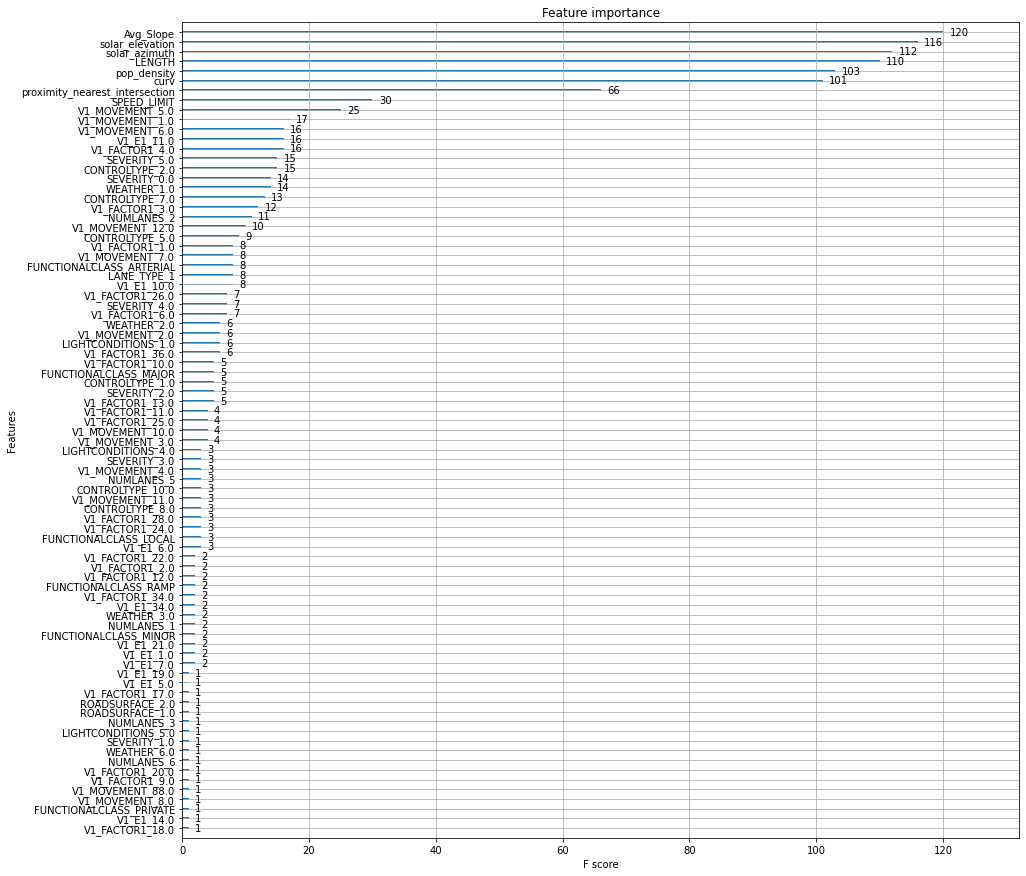

In [16]:
plt.figure(figsize=(15,15))
xgb.plot_importance(bst,ax=plt.gca(),importance_type='weight')

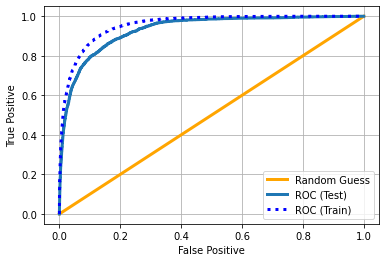

In [17]:
y_pred_test = bst.predict(dtest)
fpr, tpr, thresholds = roc_curve(y_test,y_pred_test)
y_pred_train = bst.predict(dtrain)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot([0,1],[0,1],'r-',label='Random Guess',color='orange',lw=3)
plt.plot(fpr,tpr,label='ROC (Test)',lw=3)
plt.plot(fpr_train,tpr_train,'r:',label='ROC (Train)',color='blue',lw=3)
plt.grid()
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.legend()

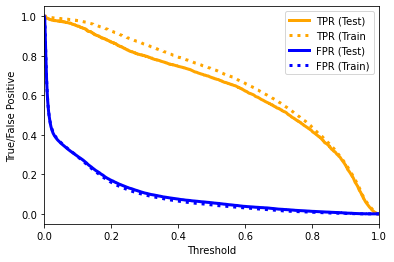

In [18]:
plt.plot(thresholds,tpr,'r-',label='TPR (Test)',color='orange',lw=3)
plt.plot(thresholds_train,tpr_train,'r:',label='TPR (Train',color='orange',lw=3)
plt.plot(thresholds,fpr,'r-',label='FPR (Test)',color='blue',lw=3)
plt.plot(thresholds_train,fpr_train,'r:',label='FPR (Train)',color='blue',lw=3)
plt.gca().set_xbound(lower=0,upper=1)
plt.xlabel('Threshold')
plt.ylabel('True/False Positive')
plt.legend()

<Figure size 1080x1080 with 0 Axes>

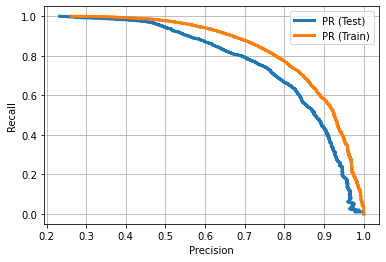

In [19]:
plt.figure(figsize=(15,15))

y_pred_test = bst.predict(dtest)
y_pred_train = bst.predict(dtrain)

precision,recall,thresholds = precision_recall_curve(y_test,y_pred_test)
precision_train, recall_train, thresholds_train = precision_recall_curve(y_train,y_pred_train)
fig,ax = plt.subplots()
plt.plot(precision,recall,label='PR (Test)',lw=3)
plt.plot(precision_train,recall_train,label='PR (Train)',lw=3)
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.grid()
plt.legend()

In [ ]:
print(confusion_matrix(y_test,y_pred_test))
print(classification_report(y_test,y_pred_test))

In [20]:
y_pred_test = bst.predict(dtest) > 0.25
print ('Test Accuracy:',accuracy_score(y_test,y_pred_test))
print ('Test F1:',f1_score(y_test,y_pred_test))
print ('Test Precision:',precision_score(y_test,y_pred_test))
print ('Test Recall:',recall_score(y_test,y_pred_test))
y_pred_test = bst.predict(dtest)
print ('Test AUC:',roc_auc_score(y_test,y_pred_test))
print ('Test AP:',average_precision_score(y_test,y_pred_test))

y_pred_train = bst.predict(dtrain) > 0.25
print ('Train Accuracy:',accuracy_score(y_train,y_pred_train))
print ('Train F1:',f1_score(y_train,y_pred_train))
print ('Train Precision:',precision_score(y_train,y_pred_train))
print ('Train Recall:',recall_score(y_train,y_pred_train))
y_pred_train = bst.predict(dtrain)
print ('Train AUC:',roc_auc_score(y_train,y_pred_train))
print ('Test AP:',average_precision_score(y_train,y_pred_train))

Test Accuracy: 0.8581029810298103
Test F1: 0.7271779908295122
Test Precision: 0.6477905681396212
Test Recall: 0.8287410926365796
Test AUC: 0.9310794006378605
Test AP: 0.8180259158757708
Train Accuracy: 0.880833468837836
Train F1: 0.7721417784489651
Train Precision: 0.6816720257234726
Train Recall: 0.8903001126702857
Train AUC: 0.9556194450426684
Test AP: 0.8721636966224307


#### We can plot Shap graph to see impact on the feature value for the output
SHAP shows the positive and negative relationships of the predictors with the target variable

In [21]:
shap_values = shap.TreeExplainer(bst).shap_values(x_test)

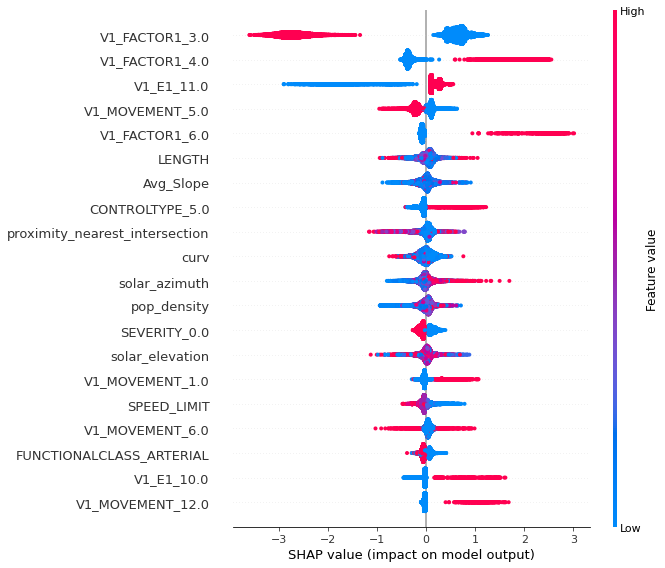

In [22]:
shap.summary_plot(shap_values, x_test)

### Let's use ESRI GeoAnalytics Random Forest Classification to compare XGBoost model.

In [10]:
## get working space and featureclass
prjPath=r'C:\projects\ESRICrash\CrashAnalysisDOT\CobbCrashAnalysis\CobbCrashAnalysis.gdb'
#input= os.path.join(prjPath,'rightangleRFS')
output= os.path.join(prjPath,'RFSprediction')
arcpy.env.workspace=prjPath
arcpy.env.overwriteOutput=True

In [11]:
print ([f.name for f in arcpy.ListFields('rightangleRFS')])

['OBJECTID', 'Shape', 'ACCIDENTDATE', 'ROADSURFACE', 'SEVERITY', 'WEATHER', 'DESCRIPTION', 'CONTROLTYPE', 'LIGHTCONDITIONS', 'V1_MOVEMENT', 'V1_FACTOR1', 'V1_E1', 'pop_density', 'proximity_nearest_intersection', 'FUNCTIONALCLASS', 'NUMLANES', 'SPEED_LIMIT', 'LANE_TYPE', 'LENGTH', 'curv', 'Avg_Slope', 'RIGHTANGLE', 'solar_azimuth', 'solar_elevation']


In [32]:
arcpy.stats.Forest("TRAIN",
                   "rightangleRFS",
                   variable_predict="RIGHTANGLE",
                   treat_variable_as_categorical="CATEGORICAL",
                   explanatory_variables="ROADSURFACE true;SEVERITY true;WEATHER true;CONTROLTYPE true;LIGHTCONDITIONS true;V1_MOVEMENT true;V1_FACTOR1 true;V1_E1 true;pop_density false;proximity_nearest_intersection false;FUNCTIONALCLASS true;NUMLANES true;SPEED_LIMIT false;LANE_TYPE true;LENGTH false;curv false;Avg_Slope false;solar_azimuth false;solar_elevation false",
                   output_importance_table="RFSimportance",
                   number_of_trees=100,
                   minimum_leaf_size=5,
                   compensate_sparse_categories="TRUE")       

id,value
0,
1,
2,
3,C:\projects\ESRICrash\CrashAnalysisDOT\CobbCrashAnalysis\CobbCrashAnalysis.gdb\RFSimportance
4,
5,
6,


![](media/rfsimportance.PNG)

### Output analysis
We can see both algorithems agrees on top 8 variables that contribute the right angle crashes with slight different orders proximity to the nearest intersection, average slope, popuation density,solar azimuth,solar elevation,segment curvature,segment length, speed limit. The F1 Score, recall and accurancy all indicate Random Forest classifier outperform XGBoost classifier by slightly margin.